In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
# datasets
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch.nn.functional as F

In [2]:
BATCH_SIZE = 128
IMG_SIZE = 64

def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x*2)-1)
    ])

    train  = torchvision.datasets.StanfordCars(root='/ssd_scratch/cvit/anirudhkaushik/datasets/stanford-car-dataset-by-classes-folder/car_data/', split="train", download=False, transform=data_transforms)
    test   = torchvision.datasets.StanfordCars(root='/ssd_scratch/cvit/anirudhkaushik/datasets/stanford-car-dataset-by-classes-folder/car_data/', split="test", download=False, transform=data_transforms)


    return torch.utils.data.ConcatDataset([train, test])


data = load_transformed_dataset()
data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

In [3]:
from noise_scheduler import NoiseScheduler
beta_start = 0.0001
beta_end = 0.02
timesteps = 300


noise_scheduler = NoiseScheduler(beta_start, beta_end, timesteps, 32)
noise_scheduler.beta_scheduler()

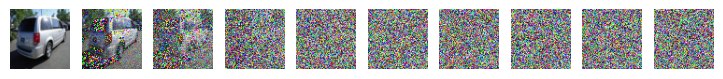

In [4]:
image = next(iter(data_loader))[0]

plt.figure(figsize=(10,10))
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(0, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int((idx/stepsize)+1))
    # remove axis of subplot
    plt.axis('off')
    image, noise  = noise_scheduler.forward_diffusion(image, t)
    noise_scheduler.show(image.cpu().detach())

In [5]:
from unet import SimpleUNET

model = SimpleUNET()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62433123


SimpleUNET(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d

In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = noise_scheduler.forward_diffusion(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

cuda:0
Epoch: 0, Loss: 0.8094525337219238, step: 000


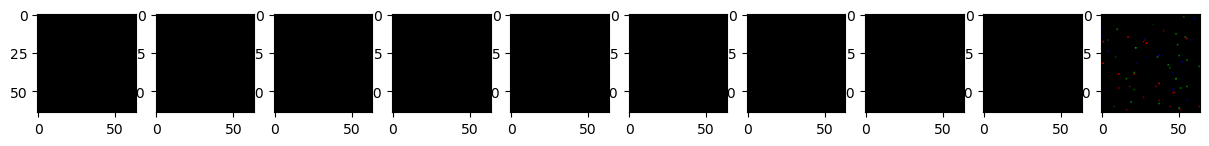

In [7]:
from torch.optim import Adam

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (BATCH_SIZE,), device=device).long()

        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch %5 == 0 and step == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}, step: {step:03d}")
            noise_scheduler.sample_plot_image(IMG_SIZE, model)